In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set() 
import re


def extract_blood_pressure_variable(col_names, key='bpsys|bpdia', include_bpdate=True):
    if include_bpdate:
        condition = 'bpdate'+'|'+key
        
    else:
        condition = key
    bp_pattern = re.compile(r''+condition, re.IGNORECASE)
    bp_variable_ind = col_names.apply(bp_pattern.search).astype(bool)
    bp_variable = col_names[bp_variable_ind]    
    return(bp_variable)

def obtain_blood_pressure_table(bp_variable, df):
    selected_variable = ['wcid']+list(bp_variable)
    bp_df = df[selected_variable].copy()
    return(bp_df)

def describe_feature_per_pat(df, feature="visit_id", grp_by='wcid'):
    '''
    Summary discription of number of visits per pat
    '''
    feature_per_pat = df.groupby(grp_by)[feature].nunique().reset_index()
    # count_encounter_id means number of encounter_id one patient has
    feature_per_pat.rename(columns={feature: 'count_feature'}, inplace=True)
    ax = feature_per_pat['count_feature'].hist(bins=100)
    ax.set_xlabel('Number of '+feature, fontsize=20)
    ax.set_ylabel('Counts of patients', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    print(feature_per_pat['count_feature'].describe())
    print(feature_per_pat['count_feature'].value_counts())

def total_days(time_series1, time_series2):
    '''
    Convert the resolution of time to days
    '''
    time_series1 = pd.to_datetime(time_series1)
    time_series2 = pd.to_datetime(time_series2)
    time_delta = time_series1-time_series2
    time_delta_days = time_delta.apply(lambda x: x.total_seconds()/
                            (3600*24))
    return time_delta_days
def create_time_gap_var(df):
    for i in range(9):
        if i == 0:
            new_bp_date='m'+'0'+str(3*i)+'_days'
            df[new_bp_date]=total_days(df['bpdate_m00'], df['bpdate_m00'])
        elif i<=3:
            old_bp_date1 = 'bpdate_m0'+str(3*i)
            old_bp_date2 = 'bpdate_m0'+str(3*(i-1))
            new_bp_date='m'+str(3*(i-1))+str(3*i)+'_days'
            df[new_bp_date]=total_days(df[old_bp_date1],df[old_bp_date2]) 
        elif i==4:
            old_bp_date1 = 'bpdate_m'+str(3*i)
            old_bp_date2 = 'bpdate_m0'+str(3*(i-1))
            new_bp_date = 'm'+str(3*(i-1))+str(3*i)+'_days'
            df[new_bp_date] =      total_days(df[old_bp_date1],df[old_bp_date2])   
        else:
            old_bp_date1 = 'bpdate_m'+str(3*i)
            old_bp_date2 = 'bpdate_m'+str(3*(i-1))
            new_bp_date = 'm'+str(3*(i-1))+str(3*i)+'_days'
            df[new_bp_date] =      total_days(df[old_bp_date1],df[old_bp_date2])
    return df

def create_cumulative_time_gap_var(df):
    # Since m00_days has been calculated before, we don't calculate it here
    for i in range(1,9):
        if i<=3:
            old_bp_date = 'bpdate_m0'+str(3*i)
            new_bp_date = 'm0'+str(3*i)+'_days'
            df[new_bp_date] = total_days(df[old_bp_date], df['bpdate_m00'])
        else:
            old_bp_date = 'bpdate_m'+str(3*i)
            new_bp_date = 'm0'+str(3*i)+'_days'
            df[new_bp_date] = total_days(df[old_bp_date], df['bpdate_m00'])
    return df


## Load the data and extract the blood pressure table

In [2]:
syv_su_patient_df = pd.read_excel('SyV Su data/SyV Su clinica patient data set.xlsx')
col_names = syv_su_patient_df.columns
col_names = pd.Series(col_names)
bp_variable = extract_blood_pressure_variable(col_names)
sysbp_variable = extract_blood_pressure_variable(col_names, key='bpsys')
diabp_variable = extract_blood_pressure_variable(col_names, key='bpdia')
sysbp_df = obtain_blood_pressure_table(sysbp_variable, df=syv_su_patient_df)
diabp_df = obtain_blood_pressure_table(diabp_variable, df=syv_su_patient_df)

## WCID

count    1848.000000
mean        1.040584
std         0.197379
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: count_feature, dtype: float64
1    1773
2      75
Name: count_feature, dtype: int64


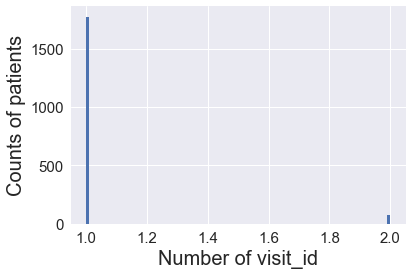

In [4]:
num_uniq_wcid = sysbp_df['wcid'].nunique()  # 1848 
#num_uniq_exid = sysbp_df['exid'].nunique()  # 1848 
sum(sysbp_df['wcid'].isna())  # no missing
# Check the replicate wcid
dup_ind = sysbp_df.duplicated(subset='wcid', keep=False)
dup_df = sysbp_df[dup_ind]
# Introduce visit id to see how many visit id one patient may have
n = sysbp_df.shape[0]
sysbp_df.loc[:,'visit_id'] = range(n)
describe_feature_per_pat(sysbp_df, feature="visit_id", grp_by='wcid')

## Create m00_days, m03_days, m36_days....

In [5]:
sysbp_df.columns = map(str.lower, sysbp_df.columns)
sysbp_df = create_time_gap_var(sysbp_df)
sysbp_df

,wcid,bpdate_m00,bpsys_m00,bpdate_m03,bpsys_m03,bpdate_m06,bpsys_m06,bpdate_m09,bpsys_m09,bpdate_m12,...,visit_id,m00_days,m03_days,m36_days,m69_days,m912_days,m1215_days,m1518_days,m1821_days,m2124_days
0,137-1098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2014-10-08,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,137-375,2017-06-29,112.0,2017-09-12,120.0,2017-11-02,126.0,2018-03-16,140.0,NaT,...,1,0.0,75.0,51.0,134.0,NaN,NaN,NaN,NaN,NaN
2,137-375,2013-10-16,110.0,2014-01-15,124.0,2014-04-02,100.0,2014-07-24,98.0,2014-10-23,...,2,0.0,91.0,77.0,113.0,91.0,77.0,NaN,NaN,NaN
3,137-631,2013-10-16,120.0,NaT,NaN,2014-04-16,128.0,2014-07-19,127.0,2014-10-24,...,3,0.0,NaN,NaN,94.0,97.0,108.0,NaN,NaN,NaN
4,137-914,2013-10-17,118.0,NaT,NaN,2014-04-12,123.0,2014-07-15,121.0,2014-10-18,...,4,0.0,NaN,NaN,94.0,95.0,NaN,NaN,NaN,NaN
5,137-556,2013-10-17,130.0,2014-01-15,140.0,2014-04-17,118.0,2014-07-21,136.0,2014-10-23,...,5,0.0,90.0,92.0,95.0,94.0,74.0,NaN,NaN,NaN
6,137-1280,2013-10-17,151.0,NaT,NaN,2014-04-28,138.0,2014-07-10,140.0,2014-10-15,...,6,0.0,NaN,NaN,73.0,97.0,NaN,NaN,NaN,NaN
7,137-635,2013-10-18,113.0,NaT,NaN,2014-04-16,100.0,NaT,NaN,2014-10-24,...,7,0.0,NaN,NaN,NaN,NaN,108.0,NaN,NaN,NaN
8,137-836,NaT,NaN,2017-12-05,110.0,2018-02-23,112.0,NaT,NaN,NaT,...,8,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN
9,137-836,2013-10-18,113.0,NaT,NaN,NaT,NaN,2014-07-19,92.0,2014-10-28,...,9,0.0,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN


## Create m00_days, m03_days, m06_days...

In [6]:
# Since if bpdate_m00 is missing, m03_days , m06_days and etc are missing
# Here firstly check missing bpdate_m00 
bpdate_m00_mis_ind =  sysbp_df['bpdate_m00'].isna()       
sum(bpdate_m00_mis_ind)

240

In [7]:
sysbp_df[bpdate_m00_mis_ind]

,wcid,bpdate_m00,bpsys_m00,bpdate_m03,bpsys_m03,bpdate_m06,bpsys_m06,bpdate_m09,bpsys_m09,bpdate_m12,...,visit_id,m00_days,m03_days,m36_days,m69_days,m912_days,m1215_days,m1518_days,m1821_days,m2124_days
0,137-1098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2014-10-08,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,137-836,NaT,NaN,2017-12-05,110.0,2018-02-23,112.0,NaT,NaN,NaT,...,8,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN
31,137-790,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,137-539,NaT,NaN,2014-04-10,153.0,2014-07-08,110.0,2014-10-08,132.0,2015-01-06,...,43,NaN,NaN,89.0,92.0,90.0,90.0,NaN,NaN,NaN
47,137-695,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,137-54285,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,137-542,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2015-01-22,...,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,137-425,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2015-01-23,...,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,137-403,NaT,NaN,2014-04-17,137.0,2014-07-10,115.0,2014-10-23,140.0,NaT,...,64,NaN,NaN,84.0,105.0,NaN,NaN,NaN,NaN,NaN
65,137-379,NaT,NaN,2014-04-03,127.0,NaT,NaN,2014-10-23,135.0,2015-01-15,...,65,NaN,NaN,NaN,NaN,84.0,90.0,NaN,NaN,NaN


### Two wcid without missing m_00 date but with m_00 value

In [11]:
sysbp_df[sysbp_df['wcid'].isin(['137-274879','137-35203'])]

,wcid,bpdate_m00,bpsys_m00,bpdate_m03,bpsys_m03,bpdate_m06,bpsys_m06,bpdate_m09,bpsys_m09,bpdate_m12,...,visit_id,m00_days,m03_days,m36_days,m69_days,m912_days,m1215_days,m1518_days,m1821_days,m2124_days
750,137-35203,NaT,138.0,2015-07-17,132.0,2015-10-13,112.0,2016-01-14,124.0,2016-04-07,...,750,NaN,NaN,88.0,93.0,84.0,98.0,NaN,NaN,NaN
1042,137-274879,NaT,130.0,2016-02-16,110.0,2016-05-25,90.0,2016-08-18,121.0,2016-11-16,...,1042,NaN,NaN,99.0,85.0,90.0,NaN,NaN,NaN,NaN


In [12]:
sysbp_df = create_cumulative_time_gap_var(sysbp_df)
sysbp_df

,wcid,bpdate_m00,bpsys_m00,bpdate_m03,bpsys_m03,bpdate_m06,bpsys_m06,bpdate_m09,bpsys_m09,bpdate_m12,...,m1518_days,m1821_days,m2124_days,m06_days,m09_days,m012_days,m015_days,m018_days,m021_days,m024_days
0,137-1098,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,2014-10-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,137-375,2017-06-29,112.0,2017-09-12,120.0,2017-11-02,126.0,2018-03-16,140.0,NaT,...,NaN,NaN,NaN,126.0,260.0,NaN,NaN,NaN,NaN,NaN
2,137-375,2013-10-16,110.0,2014-01-15,124.0,2014-04-02,100.0,2014-07-24,98.0,2014-10-23,...,NaN,NaN,NaN,168.0,281.0,372.0,449.0,NaN,NaN,NaN
3,137-631,2013-10-16,120.0,NaT,NaN,2014-04-16,128.0,2014-07-19,127.0,2014-10-24,...,NaN,NaN,NaN,182.0,276.0,373.0,481.0,NaN,NaN,NaN
4,137-914,2013-10-17,118.0,NaT,NaN,2014-04-12,123.0,2014-07-15,121.0,2014-10-18,...,NaN,NaN,NaN,177.0,271.0,366.0,NaN,NaN,NaN,NaN
5,137-556,2013-10-17,130.0,2014-01-15,140.0,2014-04-17,118.0,2014-07-21,136.0,2014-10-23,...,NaN,NaN,NaN,182.0,277.0,371.0,445.0,NaN,NaN,NaN
6,137-1280,2013-10-17,151.0,NaT,NaN,2014-04-28,138.0,2014-07-10,140.0,2014-10-15,...,NaN,NaN,NaN,193.0,266.0,363.0,NaN,NaN,NaN,NaN
7,137-635,2013-10-18,113.0,NaT,NaN,2014-04-16,100.0,NaT,NaN,2014-10-24,...,NaN,NaN,NaN,180.0,NaN,371.0,479.0,NaN,NaN,NaN
8,137-836,NaT,NaN,2017-12-05,110.0,2018-02-23,112.0,NaT,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,137-836,2013-10-18,113.0,NaT,NaN,NaT,NaN,2014-07-19,92.0,2014-10-28,...,NaN,NaN,NaN,NaN,274.0,375.0,NaN,NaN,NaN,NaN


## EDA

(25, 150)

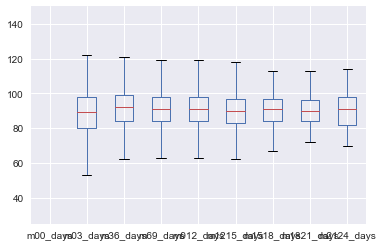

In [13]:
# Boxplot for the time gap variables
ax = sysbp_df.loc[:,'m00_days':'m2124_days'].boxplot()
ax.set_ylim([25, 150])

count    1848.000000
mean        3.496753
std         1.674675
min         0.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        10.000000
Name: count_feature, dtype: float64
4     459
3     369
5     366
1     250
2     216
6      89
0      37
7      32
8      22
9       7
10      1
Name: count_feature, dtype: int64


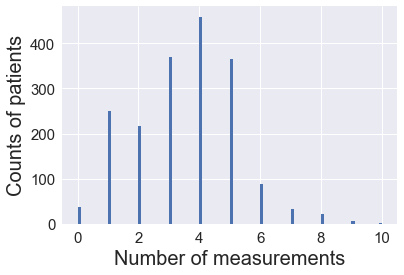

In [14]:
# Measurements per patient
sysbpvalue_variable = extract_blood_pressure_variable(col_names, key='bpsys_m', include_bpdate=False) # not include bpsys_nqv
sysbpvalue_df = obtain_blood_pressure_table(sysbpvalue_variable, df=syv_su_patient_df)
sysbpvalue_df_wide_form = pd.melt(sysbpvalue_df, ['wcid'])
sysbpvalue_df_wide_form.rename(columns={'value':'measurements'}, inplace=True)
describe_feature_per_pat(sysbpvalue_df_wide_form, feature="measurements", grp_by='wcid')